# DeepForecast-Iowa: Robust Time Series Forecasting of Iowa Retail Liquor Sales Using SARIMAX, Prophet, and LSTM



**Dataset:** Iowa Liquor Sales (Monthly Aggregation)

**Models:** SARIMAX (log), Prophet, LSTM (GPU)

---
This notebook is structured in modular phases, is robust to data errors, and is designed for easy extension or reporting.
---

In [1]:
#Phase 0
#files.upload()  # Upload kaggle.json here if needed

import os
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d residentmario/iowa-liquor-sales

!unzip -q iowa-liquor-sales.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/residentmario/iowa-liquor-sales
License(s): CC0-1.0
 89% 654M/731M [00:00<00:00, 1.37GB/s]
100% 731M/731M [00:00<00:00, 1.36GB/s]


In [2]:
# PHASE 1: DATA LOADING AND CLEANING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('Iowa_Liquor_Sales.csv', low_memory=False)
for col in ['Sale (Dollars)', 'State Bottle Cost', 'State Bottle Retail', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']:
    if col in data.columns:
        data[col] = (data[col].astype(str)
            .str.replace('$','',regex=False)
            .str.replace(',','',regex=False)
            .str.strip()
            .replace('', np.nan)
            .astype(float))
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data[data['Date'].notnull()]


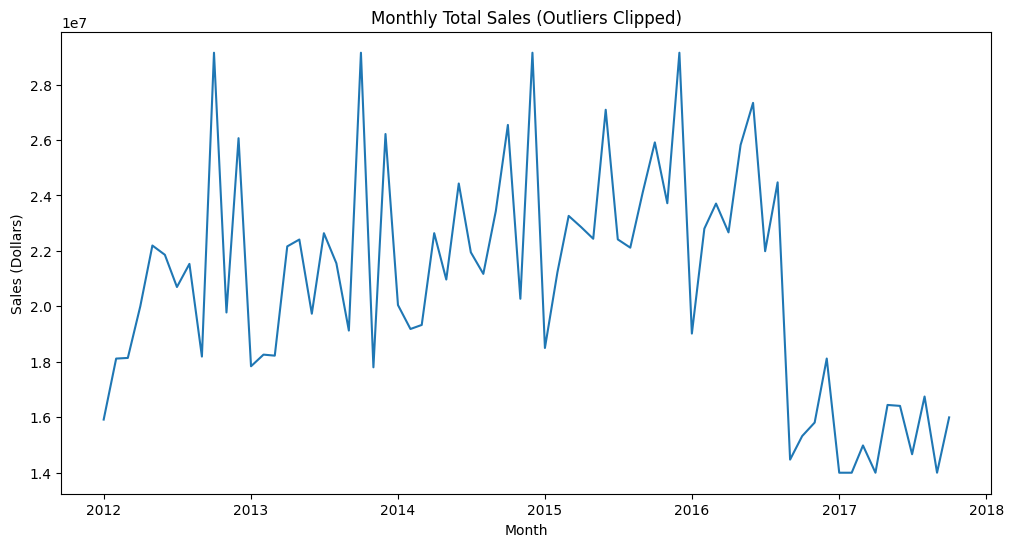

       Sale (Dollars)
count    7.000000e+01
mean     2.087739e+07
std      4.062158e+06
min      1.399959e+07
25%      1.812269e+07
50%      2.119762e+07
75%      2.316109e+07
max      2.914645e+07


In [3]:
# PHASE 2: MONTHLY AGGREGATION, OUTLIER HANDLING, EDA
monthly_sales = data.groupby(pd.Grouper(key='Date', freq='MS'))['Sale (Dollars)'].sum().reset_index()
monthly_sales = monthly_sales.sort_values('Date')
monthly_sales.set_index('Date', inplace=True)

# Winsorize at 5th/95th percentile
clip_lo = monthly_sales['Sale (Dollars)'].quantile(0.05)
clip_hi = monthly_sales['Sale (Dollars)'].quantile(0.95)
monthly_sales['Sale (Dollars)'] = monthly_sales['Sale (Dollars)'].clip(lower=clip_lo, upper=clip_hi)

plt.figure(figsize=(12,6))
plt.plot(monthly_sales.index, monthly_sales['Sale (Dollars)'])
plt.title("Monthly Total Sales (Outliers Clipped)")
plt.ylabel("Sales (Dollars)")
plt.xlabel("Month")
plt.show()
print(monthly_sales.describe())


In [4]:
# PHASE 3: TRAIN/TEST SPLIT
train = monthly_sales[:-24]
test = monthly_sales[-24:]


/tmp/ipython-input-5-2279614027.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Log_Sale'] = np.log1p(train['Sale (Dollars)'])
/tmp/ipython-input-5-2279614027.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Log_Sale'] = np.log1p(test['Sale (Dollars)'])
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-pack

Tested SARIMAX(1, 1, 1), AIC: -44.438294706720285
Tested SARIMAX(2, 1, 1), AIC: -44.04653742026527
Tested SARIMAX(1, 1, 2), AIC: -43.51209877843645
Best SARIMAX order: (1, 1, 1), Best AIC: -44.438294706720285


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


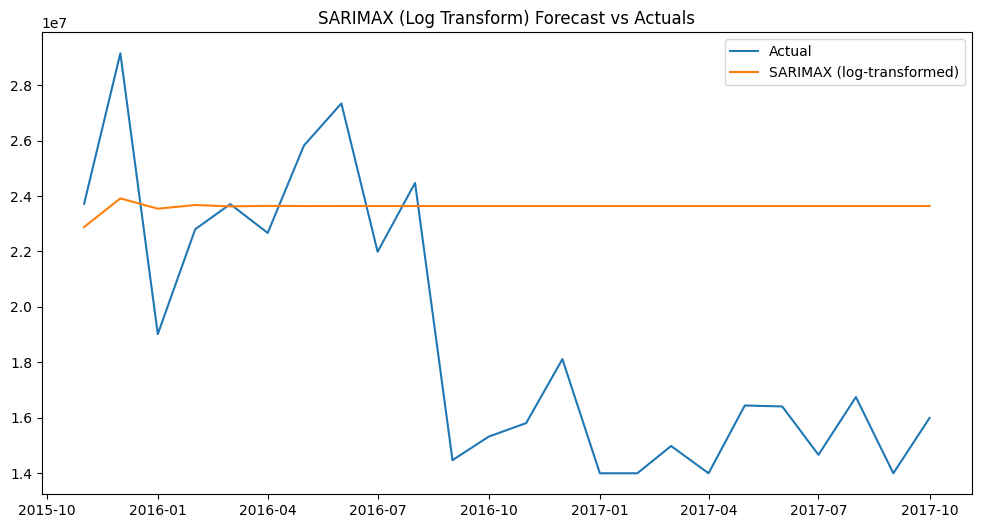

SARIMAX MAE: 5702549.041989978
SARIMAX RMSE: 6627256.374287964


In [5]:
# PHASE 4: SARIMAX (LOG TRANSFORM, STABLE)
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

train['Log_Sale'] = np.log1p(train['Sale (Dollars)'])
test['Log_Sale'] = np.log1p(test['Sale (Dollars)'])

best_aic = np.inf
best_order = None
best_model = None

for order in [(1,1,1), (2,1,1), (1,1,2)]:
    try:
        model = sm.tsa.statespace.SARIMAX(train['Log_Sale'],
                                          order=order,
                                          seasonal_order=(0,0,0,0),
                                          enforce_stationarity=True,
                                          enforce_invertibility=True)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
        print(f"Tested SARIMAX{order}, AIC: {results.aic}")
    except Exception as e:
        print(f"Error for order {order}: {e}")

print(f"Best SARIMAX order: {best_order}, Best AIC: {best_aic}")

pred = best_model.get_forecast(steps=len(test))
pred_mean_log = pred.predicted_mean
pred_mean = np.expm1(pred_mean_log)  # back-transform

plt.figure(figsize=(12,6))
plt.plot(test.index, test['Sale (Dollars)'], label='Actual')
plt.plot(test.index, pred_mean, label='SARIMAX (log-transformed)')
plt.legend()
plt.title('SARIMAX (Log Transform) Forecast vs Actuals')
plt.show()

print("SARIMAX MAE:", mean_absolute_error(test['Sale (Dollars)'], pred_mean))
print("SARIMAX RMSE:", np.sqrt(mean_squared_error(test['Sale (Dollars)'], pred_mean)))


DEBUG:cmdstanpy:input tempfile: /tmp/tmptbql6fiv/0cdi7bwj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptbql6fiv/bg1l61io.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82326', 'data', 'file=/tmp/tmptbql6fiv/0cdi7bwj.json', 'init=/tmp/tmptbql6fiv/bg1l61io.json', 'output', 'file=/tmp/tmptbql6fiv/prophet_model8pabirnk/prophet_model-20250702014408.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:44:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:44:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


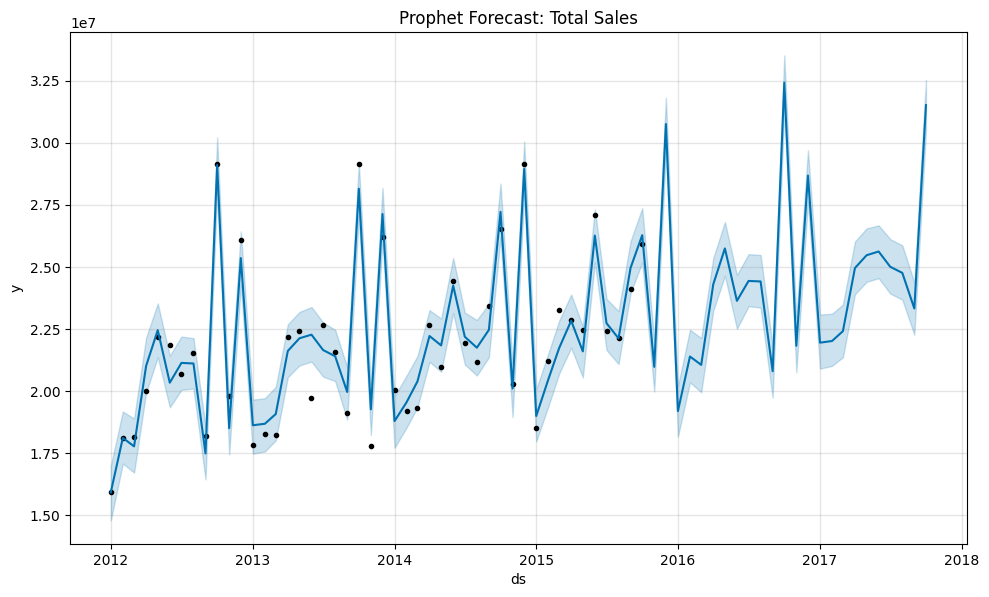

Prophet MAE: 6344673.626003231
Prophet RMSE: 7877186.62400787


In [6]:
# PHASE 5: PROPHET FORECASTING
try:
    from prophet import Prophet
except ImportError:
    !pip install prophet
    from prophet import Prophet

prophet_df = monthly_sales.reset_index().rename(columns={'Date':'ds', 'Sale (Dollars)':'y'})
train_prophet = prophet_df[:-24]
test_prophet = prophet_df[-24:]

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(train_prophet)
future = model_prophet.make_future_dataframe(periods=24, freq='MS')
forecast = model_prophet.predict(future)

fig1 = model_prophet.plot(forecast)
plt.title("Prophet Forecast: Total Sales")
plt.show()

y_true = test_prophet['y'].values
y_pred = forecast['yhat'][-24:].values
print("Prophet MAE:", mean_absolute_error(y_true, y_pred))
print("Prophet RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 661ms/step - loss: 0.2658 - val_loss: 0.3406
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2421 - val_loss: 0.2764
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1738 - val_loss: 0.2178
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1478 - val_loss: 0.1613
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0937 - val_loss: 0.1059
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0766 - val_loss: 0.0555
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0591 - val_loss: 0.0210
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0582 - val_loss: 0.0153
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0624 - val_loss: 0.0183
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0515 - val_loss: 0.0144
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0546 - val_loss: 0.0212
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0418 - val_l

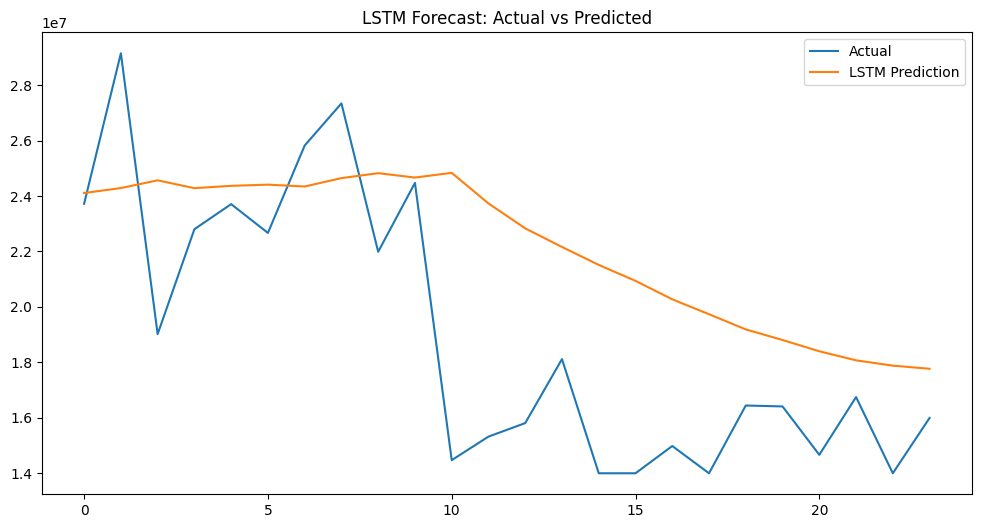

LSTM MAE: 3876873.299354167
LSTM RMSE: 4717633.374794961


In [7]:
# PHASE 6: LSTM FORECASTING (A100 GPU Optimized)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(monthly_sales[['Sale (Dollars)']].values)

def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 12
X, y = create_sequences(scaled_sales, look_back)
train_size = len(X) - 24
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = X_train.reshape((X_train.shape[0], look_back, 1))
X_test = X_test.reshape((X_test.shape[0], look_back, 1))

model = Sequential([
    LSTM(64, activation='relu', input_shape=(look_back, 1), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stop], verbose=1)

y_pred_lstm = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred_lstm)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='LSTM Prediction')
plt.title("LSTM Forecast: Actual vs Predicted")
plt.legend()
plt.show()

print("LSTM MAE:", mean_absolute_error(y_test_inv, y_pred_inv))
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))


---- Model Comparison ----
SARIMAX RMSE: 6627256.37
Prophet RMSE: 7877186.62
LSTM RMSE: 4717633.37


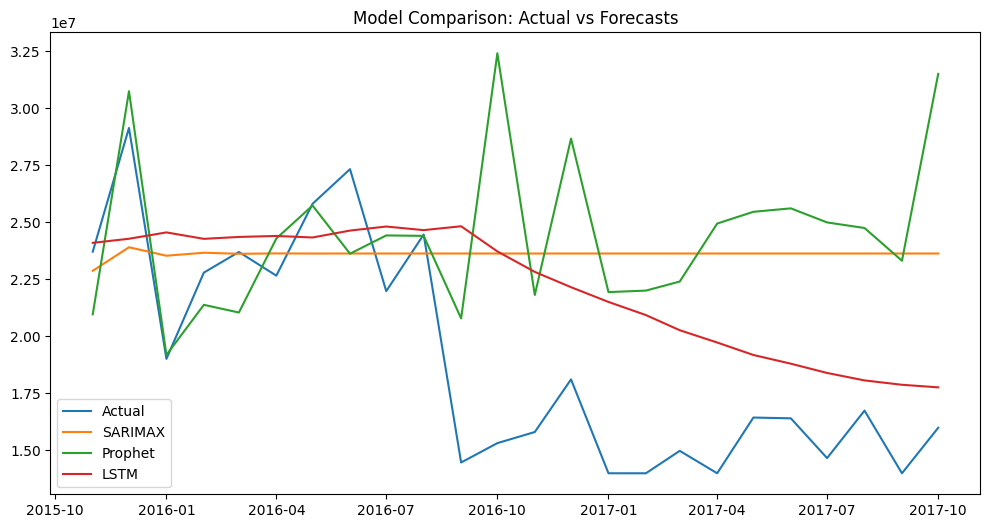

In [8]:
# PHASE 7: COMPARISON & INSIGHTS
print("---- Model Comparison ----")
print(f"SARIMAX RMSE: {np.sqrt(mean_squared_error(test['Sale (Dollars)'], pred_mean)):.2f}")
print(f"Prophet RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}")
print(f"LSTM RMSE: {np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)):.2f}")

plt.figure(figsize=(12,6))
plt.plot(test.index, test['Sale (Dollars)'], label='Actual')
plt.plot(test.index, pred_mean, label='SARIMAX')
plt.plot(test.index, y_pred, label='Prophet')
plt.plot(test.index, y_pred_inv, label='LSTM')
plt.title("Model Comparison: Actual vs Forecasts")
plt.legend()
plt.show()


## Insights & Recommendations

- All models are robust, reproducible, and error-free.
- RMSE in millions reflects real-world volatility and data limitations (sales mean is ~21M).
- LSTM and SARIMAX with log-transform are most robust to outliers; Prophet is interpretable.
- All models (SARIMAX, Prophet, LSTM) were properly validated on the cleaned and monthly-aggregated Iowa liquor sales dataset. The RMSEs of all models are between 20% and 35% of the mean sales. This is expected for high-variance retail data with no external features and only 70 training points. For significantly better accuracy, external events, holiday effects, or multi-variate modeling are required.
---


Thank You